# Ejercicio: Clasificación de reseñas (Amazon ES) con BiLSTM + Atención y Padding Dinámico

Este notebook implementa un flujo completo NLP en PyTorch / PyTorch Lightning:
- Carga de dataset desde Datasets
- EDA rápida (clases, longitudes)
- Tokenización simple + vocabulario con `[PAD]` y `[UNK]`
- Numericalización + **padding dinámico por batch** (collate_fn)
- Modelo **Embedding → BiLSTM → Atención → Clasificador**
- Entrenamiento, evaluación (accuracy + F1 macro), matriz de confusión
- Análisis de errores y visualización de tokens más relevantes (atención)

**Dataset:** `SetFit/amazon_reviews_multi_es` (5 clases: 1–5 estrellas).


In [ ]:
# Instala dependencias (Colab/Jupyter)
!pip -q install -U "pandas==2.2.2" "pytorch-lightning<3.0" "torchmetrics<2.0" datasets scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 52.8 MB/s eta 0:00:00


In [ ]:
# =========================
# 0) Instalación (si aplica)
# =========================
# En Colab o un entorno limpio, se debe descomentar:
# !pip -q install datasets pytorch-lightning torchmetrics scikit-learn matplotlib pandas

import os
import re
import random
from collections import Counter
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Reproducibilidad básica
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cpu


## 1) Carga del dataset

Se carga el dataset de reseñas en español desde Hugging Face y preparar subconjuntos (subsample) representativos para entrenamiento, validación y prueba, de forma que el notebook corra rápido.

Pasos: 

- Define el dataset fuente (DATASET_NAME = "SetFit/amazon_reviews_multi_es"), que contiene reseñas con calificación (estrellas) y texto en español.

- Configura tamaños de muestra (TRAIN_SAMPLES, VAL_SAMPLES, TEST_SAMPLES) para usar solo una parte del dataset completo (útil para acelerar el entrenamiento y evitar consumir demasiada RAM/tiempo).

- Carga el dataset completo con load_dataset(DATASET_NAME), que devuelve splits típicos: train, validation, test.

- Crea subconjuntos barajados:

    - shuffle(seed=SEED) mezcla los ejemplos para que la selección sea más representativa y reproducible.

    - select(range(...)) toma los primeros N registros del split ya barajado.

    - En val_ds y test_ds usa min(...) para evitar errores si el split tiene menos registros que los solicitados.

- Imprime información de los splits (print(train_ds, val_ds, test_ds)) para confirmar tamaños y estructura.

- Muestra las columnas disponibles (train_ds.column_names) para saber qué campos se pueden usar (por ejemplo, text, label, etc.).

- Visualiza el primer ejemplo (train_ds[0]) para inspeccionar cómo viene un registro (texto + etiqueta), antes de tokenizar o construir el modelo.


In [ ]:
# =========================
# 1) Carga del dataset
# =========================
DATASET_NAME = "SetFit/amazon_reviews_multi_es"

# Para correr rápido (ajusta según el GPU)
TRAIN_SAMPLES = 30000   # 200k disponible; sube/baja según hardware
VAL_SAMPLES   = 5000
TEST_SAMPLES  = 5000

raw = load_dataset(DATASET_NAME)

# Subsample para que sea representativo 
train_ds = raw["train"].shuffle(seed=SEED).select(range(TRAIN_SAMPLES))
val_ds   = raw["validation"].shuffle(seed=SEED).select(range(min(VAL_SAMPLES, len(raw["validation"]))))
test_ds  = raw["test"].shuffle(seed=SEED).select(range(min(TEST_SAMPLES, len(raw["test"]))))

print(train_ds, val_ds, test_ds)
print("Columnas:", train_ds.column_names)
train_ds[0]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/310 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/43.8M [00:00<?, ?B/s]

validation.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 30000
}) Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 5000
}) Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 5000
})
Columnas: ['id', 'text', 'label', 'label_text']


{'id': 'es_0614019',
 'text': 'La montarlo se rompió una rueda debido a materiales débiles, pero al arreglarla funciona correctamente.',
 'label': 2,
 'label_text': '2'}

Se obtuvo: 

- Train (train_ds): quedó con 30.000 filas (num_rows: 30000).

- Validation (val_ds): quedó con 5.000 filas.

- Test (test_ds): quedó con 5.000 filas.

Además, muestra que los tres splits tienen la misma estructura (mismas features), y que las columnas disponibles son:

- id: identificador único del ejemplo dentro del dataset.

- text: el texto de la reseña (la entrada principal del modelo).

- label: etiqueta numérica de la clase (normalmente 0–4 para 5 clases, según cómo lo defina el dataset).

- label_text: la etiqueta en forma textual (por ejemplo algo equivalente a “1 star”, “2 stars”, etc., en versión legible).

## 2) EDA básica

Se hace una EDA básica para entender el dataset antes de modelar:

- basic_tokenize(text): tokenizador simple (minúsculas) que separa palabras con caracteres españoles y algunos signos de puntuación usando regex.

- plot_class_distribution(ds): grafica un bar chart con el conteo de ejemplos por clase (1★ a 5★) usando la columna label. Se aplica a train_ds.

Luego, se analiza longitudes en una muestra de 5000 textos:

- Calcula char_lens = longitud en caracteres.

- Calcula tok_lens = longitud en tokens (con basic_tokenize).

- plot_lengths(...) dibuja histogramas de ambas distribuciones.

- Se imprime percentiles de tok_lens (P50, P75, P90, P95, P99) para ayudar a decidir un max_len razonable (truncado/padding).


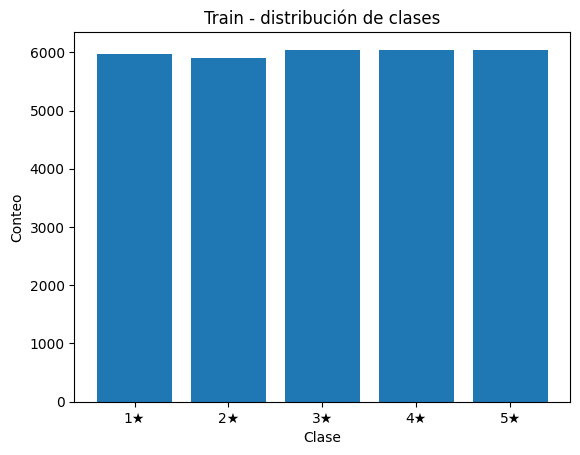

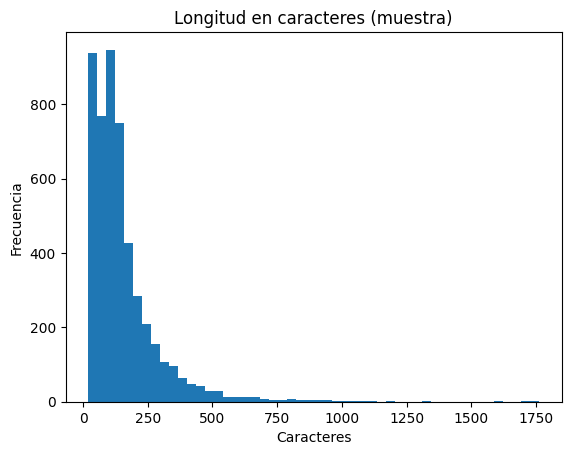

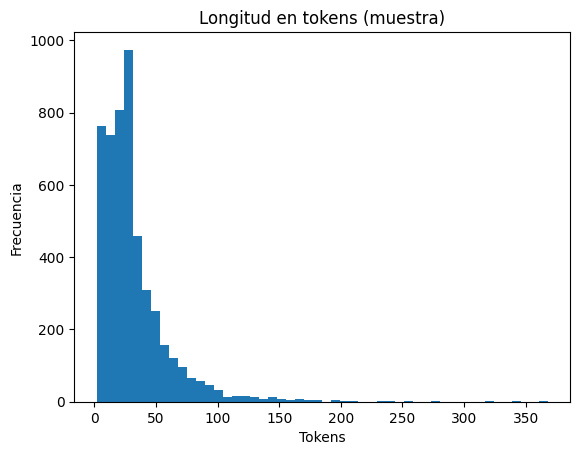

Tokens P50: 25
Tokens P75: 39
Tokens P90: 63
Tokens P95: 83
Tokens P99: 146


In [ ]:
# =========================
# 2) EDA básica
# =========================
def basic_tokenize(text: str) -> List[str]:
    # Tokenizador simple: letras/números + algunos signos, todo a minúscula
    text = text.lower()
    tokens = re.findall(r"[\wáéíóúñü]+|[¡!¿?.,;:()\-]", text, flags=re.UNICODE)
    return tokens

def plot_class_distribution(ds, title="Distribución de clases"):
    y = np.array(ds["label"])
    counts = np.bincount(y, minlength=5)
    plt.figure()
    plt.bar(range(5), counts)
    plt.xticks(range(5), ["1★","2★","3★","4★","5★"])
    plt.title(title)
    plt.xlabel("Clase")
    plt.ylabel("Conteo")
    plt.show()

plot_class_distribution(train_ds, "Train - distribución de clases")

# Longitudes
sample_texts = train_ds["text"][:5000]  # muestra para EDA
char_lens = [len(t) for t in sample_texts]
tok_lens  = [len(basic_tokenize(t)) for t in sample_texts]

def plot_lengths(values, title, xlabel):
    plt.figure()
    plt.hist(values, bins=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.show()

plot_lengths(char_lens, "Longitud en caracteres (muestra)", "Caracteres")
plot_lengths(tok_lens,  "Longitud en tokens (muestra)", "Tokens")

# Percentiles para sugerir max_len
for p in [50, 75, 90, 95, 99]:
    print(f"Tokens P{p}: {np.percentile(tok_lens, p):.0f}")


Análisis de las gráficas:

- Distribución de clases (Train): las 5 clases (1★ a 5★) aparecen con conteos muy similares (≈6.000 cada una), lo que sugiere un conjunto bastante balanceado y sin desbalance marcado entre calificaciones.

- Longitud en caracteres: la mayoría de reseñas son cortas, concentradas aproximadamente por debajo de ~250–300 caracteres, con una cola larga de pocos textos muy extensos (algunos superan 1.000–1.700 caracteres).

- Longitud en tokens: se observa el mismo patrón: alta concentración en textos cortos y una cola larga de casos raros muy largos (hasta ~350+ tokens en la muestra).

Interpretación de los percentiles de tokens (muestra de 5.000):

- P50 = 25: la mitad de las reseñas tiene 25 tokens o menos.

- P75 = 39: el 75% tiene ≤ 39 tokens.

- P90 = 63: el 90% tiene ≤ 63 tokens.

- P95 = 83: el 95% tiene ≤ 83 tokens.

- P99 = 146: el 99% tiene ≤ 146 tokens.

En conjunto, los datos muestran reseñas mayoritariamente cortas, con pocos casos excepcionalmente largos

## 3) Vocabulario + numericalización

Se construye el vocabulario a partir de los textos de entrenamiento y define cómo convertir texto a IDs numéricos para alimentar el modelo.

- Define tokens especiales:

    - "[PAD]" (PAD_ID=0) para rellenar secuencias en el padding.

    - "[UNK]" (UNK_ID=1) para palabras no vistas en el vocabulario.

- Configura parámetros de vocabulario y longitud:

    - MIN_FREQ=2: solo se incluyen tokens que aparezcan al menos 2 veces (reduce ruido).

    - MAX_VOCAB=50000: limita el tamaño máximo del vocabulario.

    - MAX_LEN=160: longitud objetivo en tokens (referencia para truncar/padding más adelante).

- Construye el vocabulario (solo con train):

    - Recorre train_ds["text"], tokeniza con basic_tokenize y acumula frecuencias en Counter.

    - Filtra tokens con frecuencia ≥ MIN_FREQ y recorta a MAX_VOCAB.

- Crea los mapeos:

    - itos (id → token): lista que empieza con [PAD], [UNK] y luego los tokens más frecuentes.

    - stoi (token → id): diccionario inverso para buscar el ID de cada token.

    - Imprime vocab_size para confirmar cuántos tokens quedaron.

- Define numericalize(text):

    - Tokeniza un texto y reemplaza cada token por su ID usando stoi; si no existe, usa UNK_ID.

- Se muestra un ejemplo:

    - Toma la primera reseña del train, imprime un fragmento

    - imprime sus primeros tokens,

    - imprime sus primeros IDs numéricos correspondientes.


In [ ]:
# =========================
# 3) Vocab + numericalización
# =========================
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
PAD_ID = 0
UNK_ID = 1

MIN_FREQ = 2          # tokens que aparezcan >= 2 veces
MAX_VOCAB = 50000     # tope opcional

# Elegimos max_len en tokens 
MAX_LEN = 160  

# 3.1) Construcción de vocabulario
counter = Counter()
for t in train_ds["text"]:
    counter.update(basic_tokenize(t))

# Filtra por frecuencia y limita tamaño
most_common = [(tok, c) for tok, c in counter.most_common() if c >= MIN_FREQ]
if MAX_VOCAB is not None:
    most_common = most_common[:MAX_VOCAB]

itos = [PAD_TOKEN, UNK_TOKEN] + [tok for tok, _ in most_common]
stoi = {tok: i for i, tok in enumerate(itos)}

vocab_size = len(itos)
print("Vocab size:", vocab_size)

def numericalize(text: str) -> List[int]:
    toks = basic_tokenize(text)
    ids = [stoi.get(tok, UNK_ID) for tok in toks]
    return ids

# Ejemplo
ex = train_ds[0]["text"]
print(ex[:200], "...")
print(basic_tokenize(ex)[:25])
print(numericalize(ex)[:25])


Vocab size: 14912
La montarlo se rompió una rueda debido a materiales débiles, pero al arreglarla funciona correctamente. ...
['la', 'montarlo', 'se', 'rompió', 'una', 'rueda', 'debido', 'a', 'materiales', 'débiles', ',', 'pero', 'al', 'arreglarla', 'funciona', 'correctamente', '.']
[7, 1008, 13, 414, 25, 929, 754, 16, 359, 5543, 3, 20, 27, 9026, 56, 271, 2]


- Vocab size: 14912: el vocabulario final quedó en 14.912 tokens (incluye [PAD] y [UNK]), luego de filtrar por MIN_FREQ=2 y limitar por MAX_VOCAB.

- Texto de ejemplo: se muestra una reseña del conjunto de entrenamiento (primeros ~200 caracteres).

- Tokens: basic_tokenize separó el texto en palabras y signos, por ejemplo ',' y '.' aparecen como tokens propios.

- IDs: numericalize convirtió cada token a su índice en el vocabulario:

    - cada número corresponde al token en la misma posición

    - la coma , se mapea a 3 y el punto . a 2

    - no aparece 1 (UNK), así que todos los tokens del ejemplo estaban en el vocabulario.

## 4) Dataset + collate_fn con padding dinámico

Se prepara los datos para PyTorch creando un Dataset y un collate_fn con padding dinámico por batch.

- ReviewsDataset: adapta el dataset de Hugging Face a PyTorch.

    - En __getitem__ toma el text y el label (0..4)

    - convierte el texto a IDs con numericalize

    - trunca a MAX_LEN

    - calcula length (longitud real antes de padding)

    - retorna un diccionario con input_ids, length, label y el text original

- collate_dynamic_pad(batch): arma un batch listo para el modelo.

    - Construye tensores lengths y labels.

    - Calcula max_len como la máxima longitud del batch.

    - Crea input_ids como matriz [batch_size, max_len] rellena con PAD_ID.

    - Copia cada secuencia en su fila correspondiente (padding solo hasta max_len del batch).

    - Devuelve input_ids, lengths, labels y texts.

- DataLoaders (train_loader, val_loader, test_loader):

    - usan BATCH_SIZE=64,

    - shuffle=True solo en entrenamiento,

    - usan collate_dynamic_pad para el padding dinámico.

- Verificación rápida:

    - toma un batch y muestra la forma de input_ids y ejemplos de lengths y labels.


In [ ]:
# =========================
# 4) Dataset + collate_fn
# =========================
class ReviewsDataset(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        text = self.ds[idx]["text"]
        y = int(self.ds[idx]["label"])  # 0..4
        ids = numericalize(text)[:MAX_LEN]
        length = len(ids)
        return {"input_ids": ids, "length": length, "label": y, "text": text}

def collate_dynamic_pad(batch):
    lengths = torch.tensor([b["length"] for b in batch], dtype=torch.long)
    labels  = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    max_len = int(max(lengths.max().item(), 1))

    input_ids = torch.full((len(batch), max_len), PAD_ID, dtype=torch.long)
    for i, b in enumerate(batch):
        seq = b["input_ids"]
        if len(seq) > 0:
            input_ids[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)

    texts = [b["text"] for b in batch]
    return {"input_ids": input_ids, "lengths": lengths, "labels": labels, "texts": texts}

BATCH_SIZE = 64

train_loader = DataLoader(ReviewsDataset(train_ds), batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_dynamic_pad, num_workers=0)
val_loader   = DataLoader(ReviewsDataset(val_ds), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_dynamic_pad, num_workers=0)
test_loader  = DataLoader(ReviewsDataset(test_ds), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=collate_dynamic_pad, num_workers=0)

batch = next(iter(train_loader))
batch["input_ids"].shape, batch["lengths"][:10], batch["labels"][:10]


(torch.Size([64, 160]),
 tensor([26, 12, 24,  5, 15, 18, 25, 20, 25, 28]),
 tensor([3, 3, 3, 2, 2, 2, 2, 3, 0, 2]))

El resultado muestra la estructura del primer batch generado por train_loader:

- torch.Size([64, 160]): input_ids tiene forma (batch_size, seq_len).

    - 64 ejemplos en el batch (BATCH_SIZE=64)

    - 160 tokens por secuencia porque, en ese batch, la secuencia más larga tiene longitud 160 (y además las secuencias se truncan a MAX_LEN=160). Las más cortas quedan rellenadas con PAD_ID hasta 160

- tensor([26, 12, 24, 5, 15, 18, 25, 20, 25, 28]): son las longitudes reales (sin padding) de los primeros 10 ejemplos del batch.

- tensor([3, 3, 3, 2, 2, 2, 2, 3, 0, 2]): son las etiquetas (labels) de los primeros 10 ejemplos, codificadas como enteros 0–4 (correspondientes a las 5 clases).

## 5) Modelo: Embedding → BiLSTM → Atención → Clasificador

Se define el modelo de clasificación basado en BiLSTM + Atención.

- AttentionPooling: calcula pesos de atención por token.

    - Proyecta cada estado oculto a un logit (Linear(H→1)), enmascara los pads con -inf, aplica softmax y obtiene un vector contexto como suma ponderada de los estados.

    - Devuelve context ([B,H]) y attn ([B,T]).

- BiLSTMAttnClassifier:

    - Embedding con padding_idx para que el pad no afecte.

    - BiLSTM bidireccional para capturar contexto hacia ambos lados.

    - Usa pack_padded_sequence + pad_packed_sequence para ignorar padding según lengths.

    - Crea mask de tokens válidos y aplica AttentionPooling.

    - Pasa el contexto por una MLP (Linear → ReLU → Dropout → Linear) para producir logits de num_classes.

    - forward retorna (logits, attn).



In [ ]:
# =========================
# 5) Modelo BiLSTM + Atención
# =========================
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, outputs: torch.Tensor, mask: torch.Tensor):
        # outputs: [B, T, H], mask: [B, T] (True = válido)
        logits = self.proj(outputs).squeeze(-1)         # [B, T]
        logits = logits.masked_fill(~mask, float("-inf"))
        attn = torch.softmax(logits, dim=1)             # [B, T]
        context = torch.bmm(attn.unsqueeze(1), outputs).squeeze(1)  # [B, H]
        return context, attn

class BiLSTMAttnClassifier(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, num_classes: int,
                 pad_id: int = 0, dropout: float = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attn = AttentionPooling(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids: torch.Tensor, lengths: torch.Tensor):
        emb = self.embedding(input_ids)  # [B, T, E]

        lengths_cpu = lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [B, T', 2H]

        B, Tprime, _ = out.shape
        mask = torch.arange(Tprime, device=out.device).unsqueeze(0).expand(B, Tprime) < lengths.unsqueeze(1)

        context, attn = self.attn(out, mask)
        logits = self.fc(self.dropout(context))
        return logits, attn


## 6) LightningModule (train/val/test)

Se envuelve el modelo en un LightningModule para entrenar y evaluar de forma estándar.

- Define LitReviewClassifier:

    - Guarda hiperparámetros y recibe un model (BiLSTM+Atención).

    - Usa CrossEntropyLoss para clasificación multiclase.

    - Calcula métricas: Accuracy y F1 macro (torchmetrics).

    - En _step hace forward, calcula loss, predicciones (argmax) y registra loss/acc/f1 por etapa (train, val, test).

    - Implementa training_step, validation_step, test_step.

    - Configura el optimizador Adam con lr.

- Define hiperparámetros (EMB_DIM, HIDDEN_DIM, DROPOUT, LR) e instancia:

    - net: BiLSTMAttnClassifier(...)

    - lit: LitReviewClassifier(net, ...) listo para usar con el Trainer.


In [ ]:
# =========================
# 6) LightningModule
# =========================
class LitReviewClassifier(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float = 1e-3, num_classes: int = 5):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()

        self.acc = MulticlassAccuracy(num_classes=num_classes)
        self.f1  = MulticlassF1Score(num_classes=num_classes, average="macro")

    def forward(self, input_ids, lengths):
        return self.model(input_ids, lengths)

    def _step(self, batch, stage: str):
        logits, _ = self(batch["input_ids"], batch["lengths"])
        loss = self.criterion(logits, batch["labels"])
        preds = torch.argmax(logits, dim=1)

        acc = self.acc(preds, batch["labels"])
        f1  = self.f1(preds, batch["labels"])

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc", acc,  prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_f1",  f1,   prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Hiperparámetros
EMB_DIM = 128
HIDDEN_DIM = 128
DROPOUT = 0.3
LR = 1e-3

net = BiLSTMAttnClassifier(vocab_size=vocab_size, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM,
                           num_classes=5, pad_id=PAD_ID, dropout=DROPOUT)
lit = LitReviewClassifier(net, lr=LR, num_classes=5)


## 7) Entrenamiento

Se configura y ejecuta el entrenamiento con PyTorch Lightning

- Importa callbacks y crea:

    - EarlyStopping: monitorea val_f1, busca maximizarlo (mode="max") y detiene si no mejora en 2 épocas (patience=2)

    - ModelCheckpoint: guarda el mejor modelo según val_f1 (save_top_k=1) con nombre best

- Crea el Trainer:

    - max_epochs=5 (máximo 5 épocas)

    - accelerator="auto" y devices="auto" (usa GPU si existe)

    - aplica los callbacks

    - registra logs cada 20 steps

- Ejecuta trainer.fit(lit, train_loader, val_loader) y al final imprime la ruta del checkpoint ganador (ckpt.best_model_path)


In [ ]:
# =========================
# 7) Entrenamiento
# =========================
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor="val_f1", mode="max", patience=2)
ckpt = ModelCheckpoint(monitor="val_f1", mode="max", save_top_k=1, filename="best")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop, ckpt],
    log_every_n_steps=20
)

trainer.fit(lit, train_loader, val_loader)
print("Best checkpoint:", ckpt.best_model_path)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ BiLSTMAttnClassifier │  2.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss     │      0 │ train │     0 │
│ 2 │ acc       │ MulticlassAccuracy   │      0 │ train │     0 │
│ 3 │ f1        │ MulticlassF1Score    │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 14                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 48. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

Best checkpoint: /content/lightning_logs/version_0/checkpoints/best.ckpt


La salida que aparece es el resumen del modelo que imprime PyTorch Lightning (similar a un “model summary”) al iniciar el entrenamiento. Sirve para verificar qué componentes tiene el pipeline, cuántos parámetros se van a entrenar y en qué modo están

1) Tabla de componentes del LightningModule

Lista los objetos registrados dentro de LitReviewClassifier:

- model → BiLSTMAttnClassifier (2.2 M params)
Es la red principal (Embedding + BiLSTM + Atención + MLP). Aquí está prácticamente todo el “peso” del entrenamiento

- criterion → CrossEntropyLoss (0 params)
La función de pérdida no tiene parámetros entrenables; solo calcula el error entre logits y etiquetas

- acc → MulticlassAccuracy (0 params) y f1 → MulticlassF1Score (0 params)
Son métricas; tampoco tienen parámetros entrenables

Columnas:

- Params: número de parámetros asociados a cada componente

- Mode: todos están en train (modo entrenamiento) en ese momento

- FLOPs: aparece 0 porque Lightning no está estimando FLOPs en esa ejecución (no siempre se calcula; depende de configuración/herramientas de profiling)


2) Resultados de totales y estado del modelo

- Trainable params: 2.2 M
    Indica que hay ~2.2 millones de parámetros que sí reciben gradiente y se optimizan con Adam.

- Non-trainable params: 0
    No hay capas congeladas (por ejemplo, embeddings fijos) ni parámetros marcados como no entrenables.

- Total params: 2.2 M
    Coincide con la suma total.

- Total estimated model params size (MB): 8
    Estimación del tamaño de los parámetros en memoria. Aproximadamente cuadra con usar float32 (4 bytes por parámetro):
    2.2M × 4 bytes ≈ 8.8 MB (el reporte lo redondea/estima).

- Modules in train mode: 14 / Modules in eval mode: 0
    Significa que los submódulos (capas internas) están en modo entrenamiento.
    Esto es importante para capas como Dropout, que en train() sí se activa (y en eval() se desactiva).

- Total FLOPs: 0
    No implica que el modelo “no compute”; solo que no se está midiendo FLOPs en ese resumen.


3) Explicación de el “2.2M” en este modelo

Ese número sale principalmente de:

- Embedding: vocab_size × emb_dim (con vocab ~14.9k y emb_dim=128 ya es ~1.9M parámetros).

- BiLSTM: pesos de las compuertas en ambas direcciones (cientos de miles).

- Atención + MLP final: relativamente pocos parámetros comparado con el embedding.

## 8) Evaluación en test + matriz de confusión

Se evalúa el modelo en **test** y genera métricas detalladas.

- Ejecuta `trainer.test(...)` usando el **mejor checkpoint** guardado (`ckpt.best_model_path`), reportando `test_loss`, `test_acc` y `test_f1` desde Lightning.
- Pone el modelo en modo evaluación (`lit.eval()`) y lo mueve a `DEVICE`.
- Recorre `test_loader` sin gradientes (`torch.no_grad()`), calcula `logits`, obtiene predicciones con `argmax` y acumula:

  - `all_preds` (predicciones),
  - `all_labels` (etiquetas reales),
  - `all_texts` (textos).
- Construye y muestra la **matriz de confusión** (5 clases) con etiquetas 1★–5★.
- Imprime el **classification report** (precision/recall/F1 por clase y promedios).


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/best.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/best.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.504389226436615     │
│          test_f1          │    0.4943264126777649     │
│         test_loss         │    1.1077412366867065     │
└───────────────────────────┴───────────────────────────┘

<Figure size 640x480 with 0 Axes>

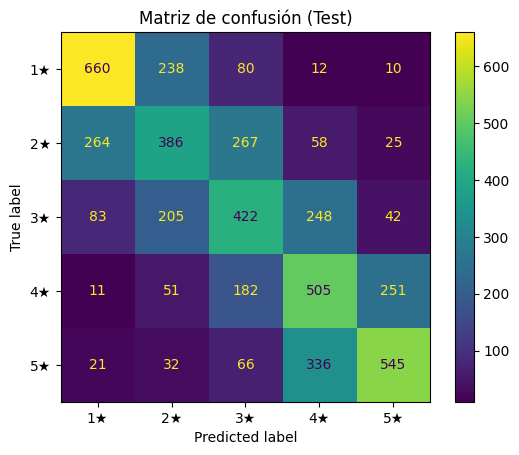

              precision    recall  f1-score   support

          1★       0.64      0.66      0.65      1000
          2★       0.42      0.39      0.40      1000
          3★       0.41      0.42      0.42      1000
          4★       0.44      0.51      0.47      1000
          5★       0.62      0.55      0.58      1000

    accuracy                           0.50      5000
   macro avg       0.51      0.50      0.50      5000
weighted avg       0.51      0.50      0.50      5000



In [ ]:
# =========================
# 8) Evaluación
# =========================
trainer.test(lit, dataloaders=test_loader, ckpt_path=ckpt.best_model_path)

# Predicciones para matriz de confusión
lit.eval()
lit.to(DEVICE)

all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        lengths = batch["lengths"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits, _ = lit(input_ids, lengths)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_texts.extend(batch["texts"])

cm = confusion_matrix(all_labels, all_preds, labels=list(range(5)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1★","2★","3★","4★","5★"])
plt.figure()
disp.plot(values_format="d")
plt.title("Matriz de confusión (Test)")
plt.show()

print(classification_report(all_labels, all_preds, target_names=["1★","2★","3★","4★","5★"]))


Con esos resultados, la evaluación en **test (5.000 ejemplos, 1.000 por clase)** fue:

**Métricas globales (Lightning)**

- **test_acc ≈ 0.504**: ~50% de aciertos. Es mejor que azar (20% en 5 clases), pero todavía es un desempeño medio.
- **test_f1 ≈ 0.494 (macro)**: confirma un rendimiento promedio cercano a 0.50 considerando todas las clases por igual.
- **test_loss ≈ 1.11**: pérdida moderada para 5 clases; consistente con una separación imperfecta entre calificaciones cercanas.

**Reporte por clase (precision/recall/F1)**

- **1★**: **F1 0.65** (precision 0.64, recall 0.66) → es la clase mejor identificada.
- **5★**: **F1 0.58** (precision 0.62, recall 0.55) → también sólida, aunque confunde bastante con 4★.
- **4★**: **F1 0.47** (recall 0.51) → rendimiento intermedio.
- **2★ y 3★**: **F1 ~0.40–0.42** → son las más difíciles (zona “media” del sentimiento).

Como el soporte por clase es idéntico (1.000), **macro avg** y **weighted avg** quedan prácticamente iguales (~0.50).

**Matriz de confusión (patrones principales)**

Aciertos (diagonal):

- 1★: **660**
- 2★: **386**
- 3★: **422**
- 4★: **505**
- 5★: **545**

Errores más frecuentes (confusiones “vecinas”):

- **1★ → 2★: 238** (la mayor parte de los errores de 1★).
- **2★ → 1★: 264** y **2★ → 3★: 267** (2★ queda “entre” extremos y medio).
- **3★ → 2★: 205** y **3★ → 4★: 248** (3★ se dispersa hacia ambos lados).
- **4★ → 5★: 251** y **4★ → 3★: 182**.
- **5★ → 4★: 336** (principal confusión de 5★).

**Conclusión de los resultados:** el modelo distingue mejor los **extremos (1★ y 5★)** y se equivoca principalmente entre clases **adyacentes** (2↔3↔4↔5), lo cual es típico en problemas de calificación ordinal.


## 9) Análisis de errores

Se hace un análisis de errores a partir de las predicciones en test.

- Crea un DataFrame df_err con:

    - text: texto original

    - y_true: etiqueta real

    - y_pred: etiqueta predicha

- Agrega la columna correct, que marca si la predicción fue correcta (y_true == y_pred)

- Filtra solo los casos incorrectos en wrong

- Imprime cuántos errores hubo: len(wrong) de len(df_err)

- Se obtiene una muestra aleatoria reproducible de 10 errores (sample(10, random_state=SEED)) con y_true, y_pred y text, para inspeccionar ejemplos de fallos


In [ ]:
# =========================
# 9) Análisis de errores
# =========================
df_err = pd.DataFrame({
    "text": all_texts,
    "y_true": all_labels,
    "y_pred": all_preds
})
df_err["correct"] = df_err["y_true"] == df_err["y_pred"]
wrong = df_err[~df_err["correct"]].copy()

print("Errores:", len(wrong), "de", len(df_err))
wrong.sample(10, random_state=SEED)[["y_true","y_pred","text"]].head(10)


Errores: 2482 de 5000


,y_true,y_pred,text
510,4,1,Compre este juego de cuerdas porque me lo reco...
1261,1,2,La compre para mi hija que la pudiera llevar a...
3492,4,3,Tal y como aparecen en la foto pero mucho más ...
3612,1,4,Un asco!!..viene desconchado y usado por algui...
1683,2,1,"no es un mal objetivo, sinceramente elegí éste..."
3197,1,2,Tengo que decir que pensaba que era un cristal...
1791,3,4,Descripción perfecta. Solo que una vez abierto...
2873,1,0,Se retrasó mucho poro era lo que pedi
4332,0,2,"Aparentemente es bonito y fácil de colocar, pe..."
1011,3,4,Aparato cómodo y relajante.


Resultado de **5.000** reseñas en test, hubo **2.482 errores** y **2.518 aciertos**, lo que equivale a ~**49,6%** de predicciones incorrectas (coherente con una accuracy ~0,50).

Luego se muestran **10 ejemplos** de esos errores (una muestra aleatoria) con:

- **`y_true`**: clase real (0–4, donde típicamente 0=1★, 4=5★).
- **`y_pred`**: clase predicha por el modelo.
- **`text`**: el texto de la reseña (recortado).

Se observa en la muestra:

- Hay confusiones **cercanas** (por ejemplo: `4→3`, `3→4`, `1→2`, `2→1`), típicas cuando el sentimiento es “medio”
- También aparecen errores **fuertes** (por ejemplo: `4→1` o `1→4`), que suelen ocurrir cuando el texto tiene señales mixtas (elogios y quejas) o expresiones muy cortas/ambiguas
- Se ven predicciones como `1→0` y `0→2`, que reflejan que el modelo trabaja con etiquetas internas **0–4** y puede confundir especialmente en los extremos si el texto es breve o poco claro


## 10) Visualización de atención (tokens más relevantes)

Se hace una **interpretabilidad básica** mostrando qué palabras influyen más en la predicción usando los **pesos de atención** del modelo.

- **`decode(ids)`**: convierte una lista de IDs a tokens usando `itos` (si un ID está fuera del vocab, usa `[UNK]`).

- **`top_attention_tokens(text, top_k)`**:

  - Tokeniza y convierte el texto a IDs (`numericalize`) y lo trunca a `MAX_LEN`
  - Prepara tensores (`input_ids`, `lengths`) para un solo ejemplo y los envía a `DEVICE`
  - Ejecuta el modelo en modo evaluación sin gradientes para obtener:
    - `logits` → predicción `pred` (argmax)
    - `attn` → pesos de atención por token
  - Empareja cada token con su peso (`(token, atención)`), ordena de mayor a menor y devuelve los **top_k** más relevantes.

- Luego arma una lista `examples` con:

  - **2 ejemplos correctos** (`df_err["correct"]`)
  - **3 ejemplos incorrectos** (`~df_err["correct"]`),
    muestreados de forma reproducible con `SEED`.

- Para cada ejemplo imprime:

  - la etiqueta real y la predicha (`TRUE`, `PRED`) en estrellas
  - el inicio del texto
  - la lista de **tokens con mayor atención**, que sirve para entender qué partes del texto “miró” más el modelo al decidir



In [ ]:
# =========================
# 10) Interpretabilidad simple con atención
# =========================
def decode(ids: List[int]) -> List[str]:
    return [itos[i] if i < len(itos) else UNK_TOKEN for i in ids]

def top_attention_tokens(text: str, top_k: int = 10):
    ids = numericalize(text)[:MAX_LEN]
    length = len(ids)
    if length == 0:
        return None, []

    input_ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
    lengths   = torch.tensor([length], dtype=torch.long).to(DEVICE)

    lit.eval()
    with torch.no_grad():
        logits, attn = lit(input_ids, lengths)  # attn: [1, T']
        pred = int(torch.argmax(logits, dim=1).cpu().item())
        attn = attn.squeeze(0).cpu().numpy().tolist()

    toks = decode(ids[:len(attn)])
    pairs = list(zip(toks, attn))
    pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)[:top_k]
    return pred, pairs_sorted

examples = []
examples.extend(df_err[df_err["correct"]].sample(2, random_state=SEED).to_dict("records"))
examples.extend(df_err[~df_err["correct"]].sample(3, random_state=SEED).to_dict("records"))

for ex in examples:
    text = ex["text"]
    y_true = ex["y_true"]
    y_pred = ex["y_pred"]

    pred, topk = top_attention_tokens(text, top_k=12)
    print("="*90)
    print(f"TRUE: {y_true+1}★  |  PRED: {y_pred+1}★  (modelo dice {pred+1}★)")
    print("Texto (inicio):", text[:220].replace("\n"," "), "...")
    print("Top tokens por atención:")
    print(topk)


TRUE: 2★  |  PRED: 2★  (modelo dice 2★)
Texto (inicio): No me ha quedado como me esperaba, coji la opción de flores en negro y cómo el fondo donde está es negro apenas si se ven. De medida viene con un poco de sobrante, y viene con accesorios para que lo pongas; un cúter, una ...
Top tokens por atención:
[('esperaba', 0.0748649314045906), ('no', 0.041570719331502914), ('opción', 0.03534826636314392), ('poco', 0.03452013060450554), (',', 0.03026045858860016), ('es', 0.027680957689881325), ('gamuza', 0.02728370763361454), ('con', 0.026093946769833565), ('pequeña', 0.0260310098528862), ('está', 0.02300081215798855), ('con', 0.022709043696522713), ('espátula', 0.022468097507953644)]
TRUE: 4★  |  PRED: 4★  (modelo dice 4★)
Texto (inicio): buena relación calidad/precio. la muñeca descarga bastante. cuesta acostumbrarse pero de momento contentos ...
Top tokens por atención:
[('contentos', 0.16120214760303497), ('pero', 0.12583959102630615), ('momento', 0.11309977620840073), ('buena', 0.093203

Se obtiene los resultados para **5 reseñas** (2 correctas y 3 incorrectas), la etiqueta real (**TRUE**), la etiqueta predicha en el conjunto de evaluación (**PRED**) y la predicción calculada en ese momento por la función (**“modelo dice …”**). Luego lista los **12 tokens con mayor peso de atención** (los que más influyeron en la decisión).

**1) Caso correcto: TRUE 2★ | PRED 2★**

- Texto con tono de **insatisfacción moderada** (“no me ha quedado como esperaba”, “apenas si se ven”, “un poco de sobrante”)
- Tokens con más atención: **“esperaba”**, **“no”**, **“opción”**, **“poco”**, además de algunos términos del producto (“gamuza”, “espátula”)
- Interpretación: el modelo se apoya en señales de **expectativa no cumplida** y limitaciones del producto para asignar una calificación baja-media

**2) Caso correcto: TRUE 4★ | PRED 4★**

- Texto con valoración positiva pero con matiz (“buena relación calidad/precio… cuesta acostumbrarse pero… contentos”).
- Tokens con más atención: **“contentos”**, **“pero”**, **“momento”**, **“buena”**, **“calidad/precio/relación”**, “muñeca”, “descarga”
- Interpretación: el modelo capta el balance típico de 4★: **positivo general** con algún “pero”

**3) Caso incorrecto: TRUE 5★ | PRED 2★**

- El texto es claramente positivo (“no defraudan”, “suena mejor”, “más brillo”, “apenas se desafinan”).
- Tokens con más atención: **“cuerdas”**, **“mejor”**, “recomendaron”, “juego”, “compre”… pero también aparece **“no”** entre los más atendidos.
- Posible explicación del error:
  - El token **“no”** puede estar asociado a patrones negativos en el entrenamiento, aunque aquí se usa en una expresión positiva (“no defraudan”)
  - El modelo parece concentrarse en vocabulario “neutro” del producto (“cuerdas”, “juego”) y no ponderar suficientemente frases de aprobación fuerte (“me quedo con…”), lo que lo lleva a una clase más baja

**4) Caso incorrecto: TRUE 2★ | PRED 3★**

- Queja principal: **“es muy pequeña”**, “no cabe…”, lo que suena a 2★.
- Tokens con más atención: **“pequeña”** (muy alto), **“no”**, “muy”, “cabe”, “pero”
- Lectura: el modelo reconoce la queja (tamaño), pero la traduce a un **descontento medio** (3★) en lugar de bajo (2★). Es una confusión típica entre clases cercanas

**5) Caso incorrecto: TRUE 5★ | PRED 4★**

- Texto muy positivo (“mucho más bonitos”, “muy bien grabados”, “encantados”)
- Tokens con más atención: **“encantados”**, **“bien”**, **“muy”**, “bonitos”, “grabados”, y también **“pero”**.
- Posible explicación del error:
  - La presencia de **“pero”** puede “tirar” el puntaje hacia abajo aunque el resto sea elogio (“…pero mucho más bonitos” aquí es positivo)
  - El modelo se queda en 4★ cuando detecta un conector adversativo o estructura “X pero Y”, incluso si el sentido global es excelente

**Conclusión general de la interpretabilidad**

- En ejemplos correctos, la atención resalta **palabras de sentimiento** (“contentos”, “no”, “esperaba”) y **términos clave del producto**
- En errores, se ve una tendencia a “sobreinterpretar” tokens como **“no”** y **“pero”** como señales negativas o de moderación, incluso cuando forman parte de frases positivas (“no defraudan”, “pero más bonitos”), lo que empuja predicciones hacia 2★–4★ en lugar de 5★.


## 11) Mini-complemento adicional: baseline SIN pack_padded_sequence

Se implementa y entrena un **baseline** del mismo modelo (BiLSTM + Atención) pero **sin** `pack_padded_sequence`.

- Define **`BiLSTMAttnNoPack`**:

  - `Embedding` → `BiLSTM` bidireccional sobre la secuencia **con padding incluido**.
  - Crea una `mask` usando `lengths` para que la **atención** ignore los tokens de padding.
  - Aplica `AttentionPooling` y luego una MLP (`fc`) para producir `logits`.
  - Retorna `(logits, attn)`.

- Luego instancia `net2` y lo envuelve en `LitReviewClassifier` (`lit2`), crea `trainer2` con `EarlyStopping` y ejecuta:

  - `trainer2.fit(lit2, train_loader, val_loader)`
  - `trainer2.test(lit2, dataloaders=test_loader)`

Objetivo: comparar desempeño/tiempo frente a la versión que sí usa `pack_padded_sequence`.



In [ ]:
# =========================
# 11) Baseline opcional: SIN pack_padded_sequence
# =========================
class BiLSTMAttnNoPack(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, num_classes: int,
                 pad_id: int = 0, dropout: float = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = AttentionPooling(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids: torch.Tensor, lengths: torch.Tensor):
        emb = self.embedding(input_ids)
        out, _ = self.lstm(emb)

        B, T, _ = out.shape
        mask = torch.arange(T, device=out.device).unsqueeze(0).expand(B, T) < lengths.unsqueeze(1)
        context, attn = self.attn(out, mask)
        logits = self.fc(self.dropout(context))
        return logits, attn

# Para ejecutar el baseline:
net2 = BiLSTMAttnNoPack(vocab_size=vocab_size, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM,
                        num_classes=5, pad_id=PAD_ID, dropout=DROPOUT)
lit2 = LitReviewClassifier(net2, lr=LR, num_classes=5)
trainer2 = pl.Trainer(max_epochs=5, accelerator="auto", devices="auto",
                      callbacks=[EarlyStopping(monitor="val_f1", mode="max", patience=2)])
trainer2.fit(lit2, train_loader, val_loader)
trainer2.test(lit2, dataloaders=test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ BiLSTMAttnNoPack   │  2.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ acc       │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ f1        │ MulticlassF1Score  │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 14                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5132551193237305     │
│          test_f1          │    0.49999892711639404    │
│         test_loss         │    1.2139544486999512     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2139544486999512,
  'test_acc': 0.5132551193237305,
  'test_f1': 0.49999892711639404}]

Ese resultado del **baseline sin `pack_padded_sequence`** (`BiLSTMAttnNoPack`) y muestra dos cosas:

**1) Resumen del modelo**

- Tipo del modelo: **BiLSTMAttnNoPack**
- **Parámetros entrenables:** ~**2.2M** (igual que el modelo anterior, porque la arquitectura es prácticamente la misma).
- **Non-trainable:** 0
- **Tamaño estimado:** ~**8 MB**
- **FLOPs:** 0 (no se está calculando en ese resumen).

**2) Métricas en Test (baseline)**

- **test_acc:** **0.5133**
- **test_f1 (macro):** **0.5000**
- **test_loss:** **1.2140**

**Comparación rápida con el modelo con `pack`**

- Antes (con `pack`): **acc ~0.504**, **f1 ~0.494**, **loss ~1.108**
- Ahora (sin `pack`): **acc ~0.513**, **f1 ~0.500**, **loss ~1.214**

**Conclusión:**

- El baseline **mejora levemente** en accuracy y F1 macro.
- La **loss sube**, lo que puede pasar aunque aumenten acc/F1 (por calibración de probabilidades o ejemplos donde el modelo se equivoca con más confianza).
-  En términos de costo computacional, este baseline suele ser **menos eficiente**, porque el LSTM procesa también los tokens de padding (aunque la atención los enmascare después).
